In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('capitals.txt', delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']

# print first five elements in the DataFrame
data.head(5)

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


In [5]:
import nltk
from gensim.models import KeyedVectors

Extract a sample of the words that we're going to analyze in this assignment for the original google news word embedding dataset, saved it in a pickle file called 'word_embeddings_capitals.p'

In [6]:
word_embeddings = pickle.load(open("word_embeddings_subset.p", "rb"))
len(word_embeddings)

243

In [16]:
len(word_embeddings), len(word_embeddings['China'])

(243, 300)

Constructing a Similarity function, cosine similarity and euclidean distance

In [17]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''

    dot = np.dot(A,B)
    norma = np.sqrt(np.dot(A,A))
    normb = np.sqrt(np.dot(B,B))
    cos = dot / (norma*normb)
    return cos

In [18]:
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510956

In [19]:
def euclidean(A, B):
    """
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between A and B.
    """
    d = np.linalg.norm(A-B)

    return d

In [20]:
euclidean(king, queen)

2.4796925

Function to predict the country for a given city

In [21]:
def get_country(city1, country1, city2, embeddings):
    """
    Input:
        city1: a string (the capital city of country1)
        country1: a string (the country of capital1)
        city2: a string (the capital city of country2)
        embeddings: a dictionary where the keys are words and values are their embeddings
    Output:
        countries: a dictionary with the most likely country and its similarity score
    """

    # store the city1, country 1, and city 2 in a set called group
    group = set((city1, country1, city2))

    # get embeddings of city 1, country1 and city 2
    city1_emb = word_embeddings[city1]
    country1_emb =  word_embeddings[country1]
    city2_emb = word_embeddings[city2]

    # get embedding of country 2
    country2_emb = country1_emb - city1_emb + city2_emb

    # Initialize the similarity to -1 (it will be replaced by a similarities that are closer to +1)
    similarity = -1
    # initialize country to an empty string
    country = ''

    # loop through all words in the embeddings dictionary andf check the nearest word to that of country2_emb
    for word in embeddings.keys():
        if word not in group:
            word_emb = word_embeddings[word]
            cur_similarity = cosine_similarity(country2_emb, word_emb)

            if cur_similarity > similarity:
                similarity = cur_similarity
                country = (word, similarity)

    return country

In [22]:
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

In [23]:
def get_accuracy(word_embeddings, data):
    '''
    Input:
        word_embeddings: a dictionary where the key is a word and the value is its embedding
        data: a pandas dataframe containing all the country and capital city pairs
    
    Output:
        accuracy: the accuracy of the model
    '''
    # initialize num correct to zero
    num_correct = 0
    # loop through the rows of the dataframe
    for i, row in data.iterrows():
        # get city1
        city1 = row['city1']
        # get country1
        country1 = row['country1']
        # get city2
        city2 =  row['city2']
        # get country2
        country2 = row['country2']

        # use get_country to find the predicted country2
        predicted_country2, _ = get_country(city1, country1, city2, word_embeddings)

        # if the predicted country2 is the same as country2
        if predicted_country2 == country2:
            # increment the number by 1
            num_correct += 1

    # length of data
    m = len(data)

    # calculate the accuracy by dividing the number correct by m
    accuracy = num_correct/m

    return accuracy

In [24]:
accuracy = get_accuracy(word_embeddings, data)
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


Got an accuracy of 92%

Using PCA to check similarity between words in a graph

In [25]:
def compute_pca(X, n_components=2):
    """
    Input:
        X: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output:
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    """
    # mean center the data
    X_demeaned = X - np.mean(X,axis=0)
    print('X_demeaned.shape: ',X_demeaned.shape)
    
    # calculate eigenvectors & eigenvalues of the covariance matrix
    covariance_matrix = np.cov(X_demeaned, rowvar=False)
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO='L')
    
    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)
    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = idx_sorted[::-1]
    
    # sort the eigen values
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]
    # sort eigenvectors 
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]

    # select the first n eigenvectors
    eigen_vecs_subset = eigen_vecs_sorted[:,0:n_components]

    # transform the data
    X_reduced = np.dot(eigen_vecs_subset.transpose(),X_demeaned.transpose()).transpose()

    return X_reduced

In [27]:
def get_vectors(embeddings, words):
    """
    Input:
        embeddings: a word 
        words: a list of words
    Output: 
        X: a matrix where the rows are the embeddings corresponding to the rows on the list
    """
    m = len(words)
    X = np.zeros((1, 300))
    for word in words:
        eng_emb = embeddings[word]
        X = np.row_stack((X, eng_emb))
    X = X[1:,:]
    return X

In [32]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town', 
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = get_vectors(word_embeddings, words)

print('You have 11 words each of 300 dimensions thus X.shape is:', X.shape)

You have 11 words each of 300 dimensions thus X.shape is: (11, 300)


X_demeaned.shape:  (11, 300)


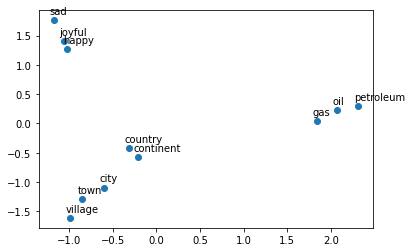

In [30]:
result = compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()